In [ ]:
import kagglehub
endofnight17j03_industrial_images_dataset_path = kagglehub.dataset_download('endofnight17j03/industrial-images-dataset')

print('Data source import complete.')


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

2025-09-21 15:02:20.684242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758466941.037171      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758466941.136922      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [ ]:
DATASET_PATH = "/kaggle/input/industrial-images-daetaset/Industrial-Equipment"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

INITIAL_EPOCHS = 15
FINE_TUNE_EPOCHS = 10
INITIAL_LEARNING_RATE = 1e-3
FINE_TUNE_LEARNING_RATE = 1e-5
FINE_TUNE_AT = 100  

print("=== Dataset Structure ===")
print("Directory contents:", os.listdir(DATASET_PATH))

=== Dataset Structure ===
Directory contents: ['Non-Defected', 'Defected']


In [ ]:
defected_count = len(os.listdir(os.path.join(DATASET_PATH, 'Defected')))
non_defected_count = len(os.listdir(os.path.join(DATASET_PATH, 'Non-Defected')))

print(f"Defected images: {defected_count}")
print(f"Non-defected images: {non_defected_count}")
print(f"Total images: {defected_count + non_defected_count}")
print(f"Class balance ratio: {defected_count/non_defected_count:.2f}")

Defected images: 3542
Non-defected images: 3348
Total images: 6890
Class balance ratio: 1.06


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=42,
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=42,
    shuffle=False 
)

print("\n=== Data Generators Info ===")
print(f"Training batches: {len(train_generator)}")
print(f"Validation batches: {len(validation_generator)}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print("Class indices:", train_generator.class_indices)

Found 5513 images belonging to 2 classes.
Found 1377 images belonging to 2 classes.

=== Data Generators Info ===
Training batches: 173
Validation batches: 44
Training samples: 5513
Validation samples: 1377
Class indices: {'Defected': 0, 'Non-Defected': 1}


In [ ]:
def create_model(input_shape=(224, 224, 3)):

    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    base_model.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ])

    return model, base_model

model, base_model = create_model()
model.summary()

I0000 00:00:1758466967.103010      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758466967.103878      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,694,913 (105.65 MB)

 Trainable params: 12,978,689 (49.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

In [ ]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),

    ModelCheckpoint(
        'best_defect_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [ ]:
print("\n=== Phase 1: Initial Training ===")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_phase1 = model.fit(
    train_generator,
    epochs=INITIAL_EPOCHS,
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=callbacks,
    verbose=1
)


=== Phase 1: Initial Training ===


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1758466976.317803     114 service.cc:148] XLA service 0x7d41240037b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758466976.319769     114 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758466976.319791     114 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758466977.058885     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/173 ━━━━━━━━━━━━━━━━━━━━ 56:36 20s/step - accuracy: 0.3750 - loss: 1.1161

I0000 00:00:1758466991.033508     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.7312 - loss: 0.5456
Epoch 1: val_accuracy improved from -inf to 0.97023, saving model to best_defect_model.h5
173/173 ━━━━━━━━━━━━━━━━━━━━ 172s 884ms/step - accuracy: 0.7316 - loss: 0.5449 - val_accuracy: 0.9702 - val_loss: 0.1285 - learning_rate: 0.0010
Epoch 2/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.8831 - loss: 0.2727
Epoch 2: val_accuracy did not improve from 0.97023
173/173 ━━━━━━━━━━━━━━━━━━━━ 99s 571ms/step - accuracy: 0.8831 - loss: 0.2726 - val_accuracy: 0.9484 - val_loss: 0.1260 - learning_rate: 0.0010
Epoch 3/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.9030 - loss: 0.2277
Epoch 3: val_accuracy improved from 0.97023 to 0.98330, saving model to best_defect_model.h5
173/173 ━━━━━━━━━━━━━━━━━━━━ 97s 561ms/step - accuracy: 0.9030 - loss: 0.2277 - val_accuracy: 0.9833 - val_loss: 0.0585 - learning_rate: 0.0010
Epoch 4/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.9113 - loss:

In [ ]:
print("\n=== Phase 2: Fine-tuning ===")

base_model.trainable = True

for layer in base_model.layers[:FINE_TUNE_AT]:
    layer.trainable = False

print(f"Unfrozen layers: {len([l for l in base_model.layers if l.trainable])}")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_phase2 = model.fit(
    train_generator,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=callbacks,
    verbose=1
)


=== Phase 2: Fine-tuning ===
Unfrozen layers: 0
Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.9520 - loss: 0.1299
Epoch 1: val_accuracy did not improve from 0.99710
173/173 ━━━━━━━━━━━━━━━━━━━━ 104s 567ms/step - accuracy: 0.9520 - loss: 0.1298 - val_accuracy: 0.9964 - val_loss: 0.0306 - learning_rate: 1.0000e-05
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.9580 - loss: 0.1135
Epoch 2: val_accuracy did not improve from 0.99710
173/173 ━━━━━━━━━━━━━━━━━━━━ 96s 554ms/step - accuracy: 0.9580 - loss: 0.1135 - val_accuracy: 0.9964 - val_loss: 0.0326 - learning_rate: 1.0000e-05
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.9549 - loss: 0.1115
Epoch 3: val_accuracy did not improve from 0.99710
173/173 ━━━━━━━━━━━━━━━━━━━━ 97s 560ms/step - accuracy: 0.9549 - loss: 0.1116 - val_accuracy: 0.9964 - val_loss: 0.0326 - learning_rate: 1.0000e-05
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.9486 - loss: 0.1346
E

In [ ]:
def combine_histories(hist1, hist2):
    combined_history = {}
    for key in hist1.history.keys():
        combined_history[key] = hist1.history[key] + hist2.history[key]
    return combined_history

total_history = combine_histories(history_phase1, history_phase2)

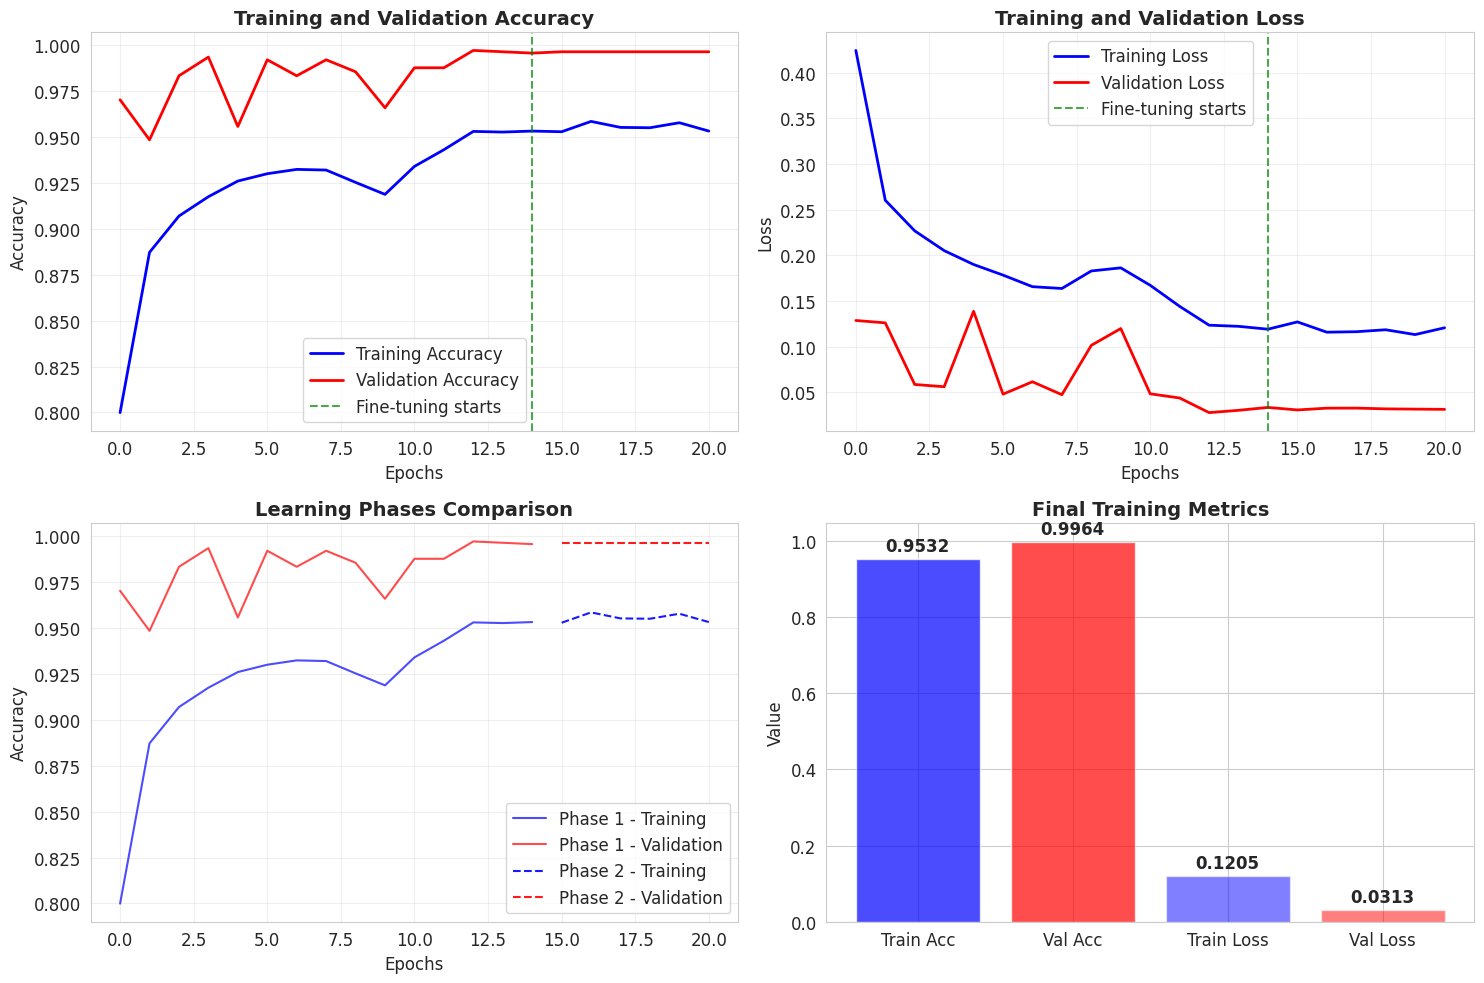

In [ ]:
def plot_training_results(history, phase1_epochs=INITIAL_EPOCHS):

    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, 'b-', label='Training Accuracy', linewidth=2)
    plt.plot(epochs_range, val_acc, 'r-', label='Validation Accuracy', linewidth=2)
    plt.axvline(x=phase1_epochs-1, color='green', linestyle='--', alpha=0.7, label='Fine-tuning starts')
    plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, 'b-', label='Training Loss', linewidth=2)
    plt.plot(epochs_range, val_loss, 'r-', label='Validation Loss', linewidth=2)
    plt.axvline(x=phase1_epochs-1, color='green', linestyle='--', alpha=0.7, label='Fine-tuning starts')
    plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 3)
    plt.plot(epochs_range[:phase1_epochs], acc[:phase1_epochs], 'b-', alpha=0.7, label='Phase 1 - Training')
    plt.plot(epochs_range[:phase1_epochs], val_acc[:phase1_epochs], 'r-', alpha=0.7, label='Phase 1 - Validation')
    plt.plot(epochs_range[phase1_epochs:], acc[phase1_epochs:], 'b--', alpha=0.9, label='Phase 2 - Training')
    plt.plot(epochs_range[phase1_epochs:], val_acc[phase1_epochs:], 'r--', alpha=0.9, label='Phase 2 - Validation')
    plt.title('Learning Phases Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 4)
    final_metrics = {
        'Train Acc': acc[-1],
        'Val Acc': val_acc[-1],
        'Train Loss': loss[-1],
        'Val Loss': val_loss[-1]
    }

    metrics_names = list(final_metrics.keys())
    metrics_values = list(final_metrics.values())
    colors = ['blue', 'red', 'blue', 'red']

    bars = []
    for i, (name, value, color) in enumerate(zip(metrics_names, metrics_values, colors)):
        alpha_val = 0.7 if 'Acc' in name else 0.5
        bar = plt.bar(name, value, color=color, alpha=alpha_val)
        bars.extend(bar)

    plt.title('Final Training Metrics', fontsize=14, fontweight='bold')
    plt.ylabel('Value')

    for bar, value in zip(bars, metrics_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

plot_training_results(total_history)


=== Model Evaluation ===
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step
Classification Report:
              precision    recall  f1-score   support

Non-Defected       1.00      0.99      1.00       708
    Defected       0.99      1.00      1.00       669

    accuracy                           1.00      1377
   macro avg       1.00      1.00      1.00      1377
weighted avg       1.00      1.00      1.00      1377



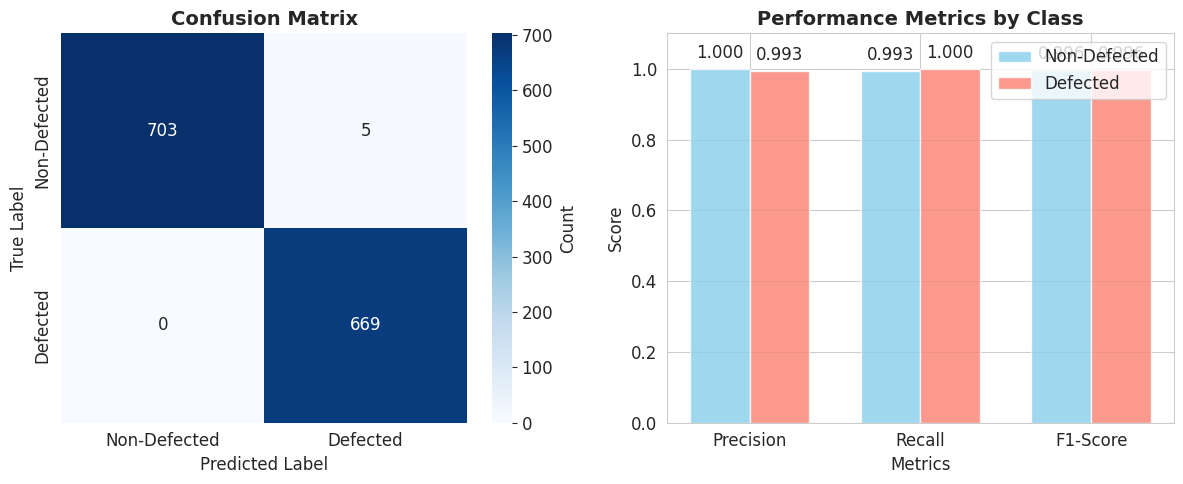


Overall Accuracy: 0.9964
Macro Average F1-Score: 0.9964
Weighted Average F1-Score: 0.9964


In [ ]:
def evaluate_model(model, validation_generator):

    print("\n=== Model Evaluation ===")

    validation_generator.reset()
    predictions = model.predict(validation_generator, steps=len(validation_generator))
    y_pred = (predictions > 0.5).astype(int).flatten()
    y_true = validation_generator.labels

    class_names = ['Non-Defected', 'Defected']
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.subplot(1, 2, 2)
    metrics = ['Precision', 'Recall', 'F1-Score']
    metric_keys = ['precision', 'recall', 'f1-score']  # sklearn uses 'f1-score' not 'f1_score'

    defected_scores = [report['Defected'][key] for key in metric_keys]
    non_defected_scores = [report['Non-Defected'][key] for key in metric_keys]

    x = np.arange(len(metrics))
    width = 0.35

    plt.bar(x - width/2, non_defected_scores, width, label='Non-Defected', alpha=0.8, color='skyblue')
    plt.bar(x + width/2, defected_scores, width, label='Defected', alpha=0.8, color='salmon')

    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Performance Metrics by Class', fontsize=14, fontweight='bold')
    plt.xticks(x, metrics)
    plt.legend()
    plt.ylim(0, 1.1)

    for i, (nd_score, d_score) in enumerate(zip(non_defected_scores, defected_scores)):
        plt.text(i - width/2, nd_score + 0.02, f'{nd_score:.3f}', ha='center', va='bottom')
        plt.text(i + width/2, d_score + 0.02, f'{d_score:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    print(f"\nOverall Accuracy: {report['accuracy']:.4f}")
    print(f"Macro Average F1-Score: {report['macro avg']['f1-score']:.4f}")
    print(f"Weighted Average F1-Score: {report['weighted avg']['f1-score']:.4f}")

    return report, cm, predictions

eval_report, conf_matrix, predictions = evaluate_model(model, validation_generator)

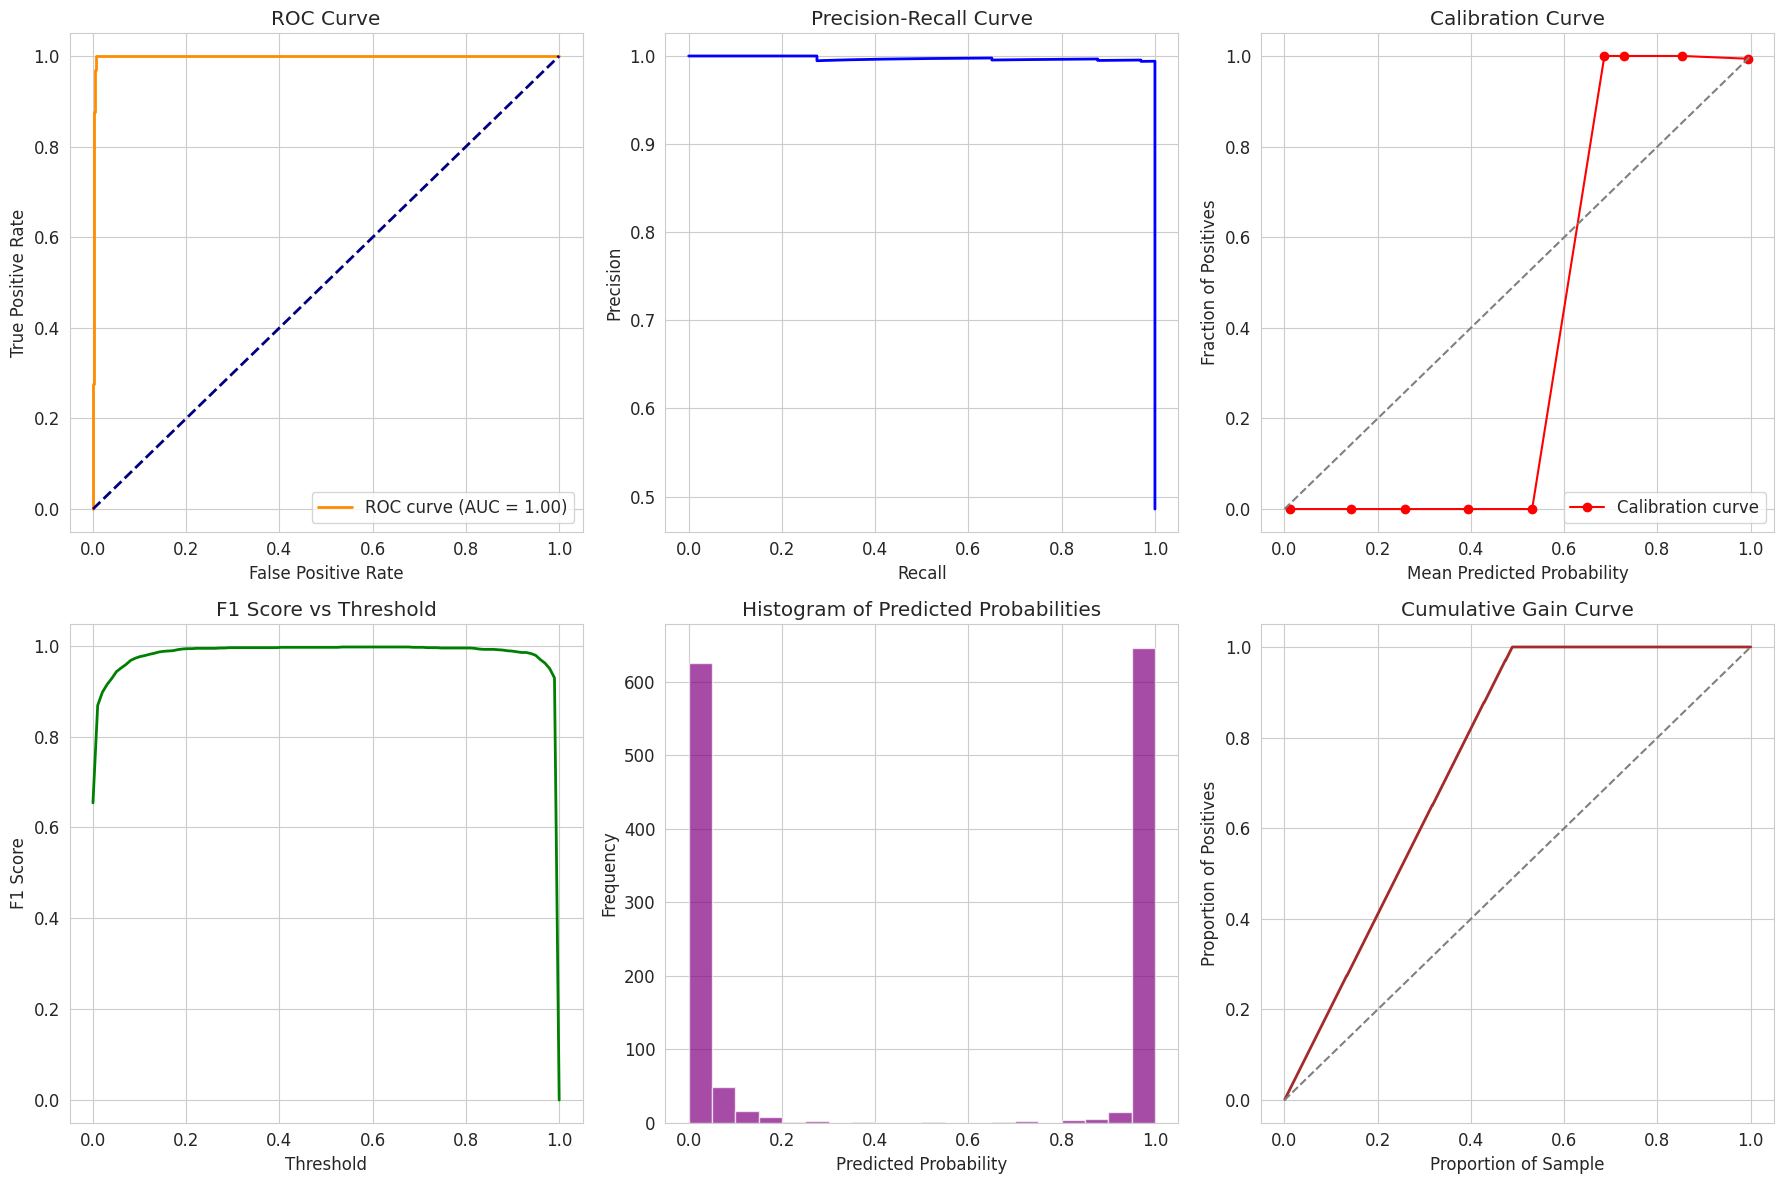

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
from sklearn.calibration import calibration_curve

y_true = validation_generator.labels
y_pred_prob = predictions.flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)
axes[0, 0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve')
axes[0, 0].legend(loc="lower right")

precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
axes[0, 1].plot(recall, precision, color='blue', lw=2)
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curve')

prob_true, prob_pred = calibration_curve(y_true, y_pred_prob, n_bins=10)
axes[0, 2].plot(prob_pred, prob_true, marker='o', color='red', label='Calibration curve')
axes[0, 2].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[0, 2].set_xlabel('Mean Predicted Probability')
axes[0, 2].set_ylabel('Fraction of Positives')
axes[0, 2].set_title('Calibration Curve')
axes[0, 2].legend(loc="lower right")

thresholds = np.linspace(0, 1, 100)
f1_scores = [f1_score(y_true, (y_pred_prob > t).astype(int)) for t in thresholds]
axes[1, 0].plot(thresholds, f1_scores, color='green', lw=2)
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_title('F1 Score vs Threshold')

axes[1, 1].hist(y_pred_prob, bins=20, color='purple', alpha=0.7)
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Histogram of Predicted Probabilities')

sorted_idx = np.argsort(-y_pred_prob)
y_sorted = y_true[sorted_idx]
cum_gain = np.cumsum(y_sorted) / np.sum(y_sorted)
percent_samples = np.arange(1, len(y_sorted)+1) / len(y_sorted)

axes[1, 2].plot(percent_samples, cum_gain, lw=2, color='brown')
axes[1, 2].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[1, 2].set_xlabel('Proportion of Sample')
axes[1, 2].set_ylabel('Proportion of Positives')
axes[1, 2].set_title('Cumulative Gain Curve')

plt.tight_layout()
plt.show()

In [ ]:
model.save('industrial_defect_detection_model.h5')
print("\n✅ Model saved as 'industrial_defect_detection_model.h5'")


✅ Model saved as 'industrial_defect_detection_model.h5'


In [ ]:
model.save('industrial_defect_detection_model2.h5')
print("✅ Model saved with .save()")

model.save_weights('defect_model.weights.h5')
print("✅ Weights saved separately")

model_json = model.to_json()
with open("defect_model_architecture.json", "w") as json_file:
    json_file.write(model_json)
print("✅ Architecture saved as JSON")

model.export("defect_model_savedformat")
print("✅ Model saved in TensorFlow SavedModel format")

try:
    test_model = tf.keras.models.load_model('industrial_defect_detection_model2.h5')
    test_input = np.random.random((1, 224, 224, 3))
    test_output = test_model.predict(test_input, verbose=0)
    print(f"✅ Loading test successful: {test_output[0][0]:.4f}")
except Exception as e:
    print(f"❌ Loading test failed: {str(e)}")

✅ Model saved with .save()
✅ Weights saved separately
✅ Architecture saved as JSON
Saved artifact at 'defect_model_savedformat'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_19')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137721938468816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137721938467280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137721938468624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137721938468432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137721938466512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137721938468048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137721938469008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137721938473616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137721938468240: TensorSpec(shape=(), dtype=tf.resource, nam

In [ ]:

def predict_defect(model, image_path, threshold=0.5):

    from tensorflow.keras.preprocessing import image

    img = image.load_img(image_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction_prob = model.predict(img_array)[0][0]
    prediction = 1 if prediction_prob > threshold else 0
    confidence = prediction_prob if prediction == 1 else 1 - prediction_prob

    result = {
        'prediction': 'Defected' if prediction == 1 else 'Non-Defected',
        'confidence': confidence,
        'probability': prediction_prob
    }

    return result

print("\n🎉 Training Complete! Model is ready for deployment.")
print(f"Final Validation Accuracy: {max(total_history['val_accuracy']):.4f}")
print(f"Final Validation Loss: {min(total_history['val_loss']):.4f}")


🎉 Training Complete! Model is ready for deployment.
Final Validation Accuracy: 0.9971
Final Validation Loss: 0.0277


In [ ]:
result = predict_defect(model, '/kaggle/input/industrial-images-dataset/Industrial-Equipment/Defected/cast_def_0_4970.jpeg')
print(f"Prediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
Prediction: Defected
Confidence: 0.9880


In [ ]:

import pandas as pd

sample_idx = np.random.choice(len(validation_generator.filenames), 30, replace=False)
sample_files = [validation_generator.filenames[i] for i in sample_idx]
sample_true = [validation_generator.classes[i] for i in sample_idx]
sample_pred = predictions[sample_idx].flatten()

df = pd.DataFrame({
    "Image": sample_files,
    "True Label": ["Defected" if t == 1 else "Non-Defected" for t in sample_true],
    "Predicted Probabilities": sample_pred,
    "Predicted Label": ["Defected" if p > 0.5 else "Non-Defected" for p in sample_pred]
})

styled_df = df.style.set_properties(**{'text-align': 'center'}) \
                   .set_caption("Sample Predictions and Actual Labels") \
                   .format({"Predicted Probabilities": "{:.4f}"}) \
                   .background_gradient(cmap='viridis', subset=["Predicted Probabilities"])

styled_df

,Image,True Label,Predicted Probabilities,Predicted Label
0,Non-Defected/Non-Defected_0_4310.jpeg,Defected,0.9965,Defected
1,Defected/defected_0_2018.jpeg,Non-Defected,0.0602,Non-Defected
2,Defected/defected_0_1629.jpeg,Non-Defected,0.0003,Non-Defected
3,Non-Defected/Non-Defected_0_3030.jpeg,Defected,1.0000,Defected
4,Non-Defected/Non-Defected_0_227.jpeg,Defected,0.9994,Defected
5,Defected/defected_0_104.jpeg,Non-Defected,0.0205,Non-Defected
6,Defected/defected_0_1309.jpeg,Non-Defected,0.0000,Non-Defected
7,Defected/defected_0_1164.jpeg,Non-Defected,0.0086,Non-Defected
8,Non-Defected/Non-Defected_0_484.jpeg,Defected,0.9947,Defected
9,Non-Defected/Non-Defected_0_3416.jpeg,Defected,0.9972,Defected
